
# 部品製造の良品率予測（サンプルノートブック）

このノートブックは、合成したデータ（Excel）を読み込み、前処理・可視化・LightGBM による学習と SHAP による特徴重要度の可視化、
さらに学習用／検証用への分割後の評価までを含むサンプルです。


In [29]:
# 必要ライブラリのインストール
#!pip install --quiet lightgbm shap openpyxl seaborn

# 合成データをダウンロード
#!curl -o manufacturing_yield_data.xlsx https://example.com/manufacturing_yield_data.xlsx

In [30]:
# 必要ライブラリのインポート
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
import lightgbm as lgb
import shap

plt.rcParams["figure.figsize"] = (6, 4) # グラフのデフォルトサイズを設定
pd.set_option("display.max_columns", 100)

# 合成データのパスを設定
data_path = Path("manufacturing_yield_sample.xlsx")  # 同ディレクトリに配置想定

## 1. データ読み込み／前処理と理解

In [31]:
# Excelから読み込み
df = pd.read_excel(data_path, sheet_name="data", engine="openpyxl")
print("shape:", df.shape) # 読み込んだデータの形状(行数、列数)を表示
df.head() # データの先頭5行を表示

shape: (1000, 14)


,timestamp,part_type,shift,machine,material_batch,temp_c,pressure_bar,speed_per_min,inspected_count,good_count,bad_count,good_rate,bad_rate,OK/NG
0,2024-06-16 07:00:00,C,Evening,M4,Mat2,192.578079,49.556930,109.775782,100,99,1,0.99,0.01,OK
1,2024-04-30 04:00:00,B,Day,M1,Mat2,209.243578,47.847708,150.471002,100,100,0,1.00,0.00,OK
2,2024-04-14 21:00:00,D,Evening,M5,Mat3,200.346119,53.982720,119.512885,100,90,10,0.90,0.10,NG
3,2024-06-22 22:00:00,C,Day,M2,Mat1,197.172043,48.820829,135.420803,100,99,1,0.99,0.01,OK
4,2024-04-20 02:00:00,A,Evening,M3,Mat2,198.938181,48.466514,119.200457,100,100,0,1.00,0.00,OK


In [32]:
# 欠損の確認
df_info = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "n_missing": df.isna().sum(),
    "missing_rate": df.isna().mean().round(3)
})
df_info

,dtype,n_missing,missing_rate
timestamp,datetime64[ns],0,0.00
part_type,object,0,0.00
shift,object,50,0.05
machine,object,50,0.05
material_batch,object,50,0.05
temp_c,float64,50,0.05
pressure_bar,float64,50,0.05
speed_per_min,float64,50,0.05
inspected_count,int64,0,0.00
good_count,int64,0,0.00


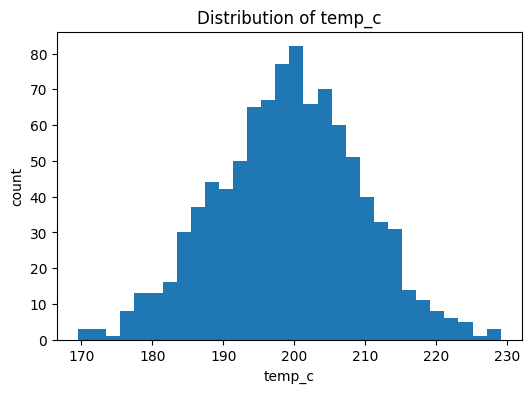

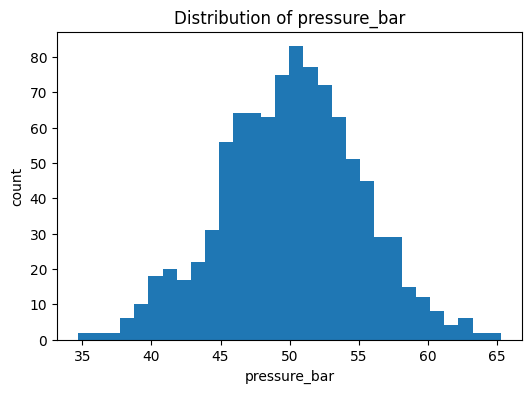

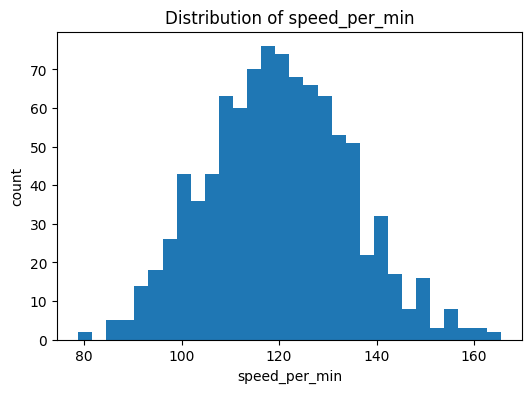

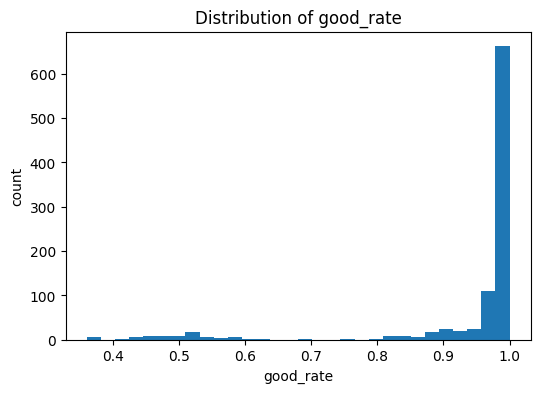

In [33]:
# 数量データの簡易的な分布（matplotlibのみ使用）
num_cols = ["temp_c", "pressure_bar", "speed_per_min", "good_rate"]
for c in num_cols:
    if c in df.columns:
        plt.figure()
        vals = df[c].dropna().values
        plt.hist(vals, bins=30)
        plt.title(f"Distribution of {c}")
        plt.xlabel(c); plt.ylabel("count")
        plt.show()

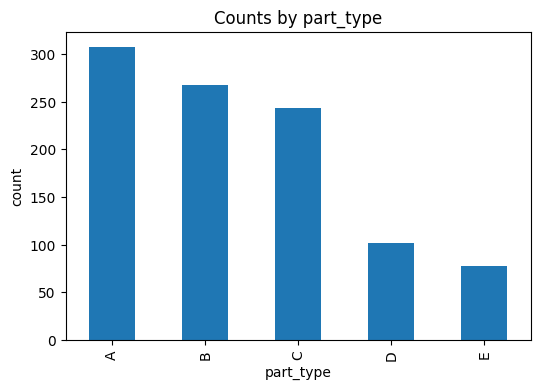

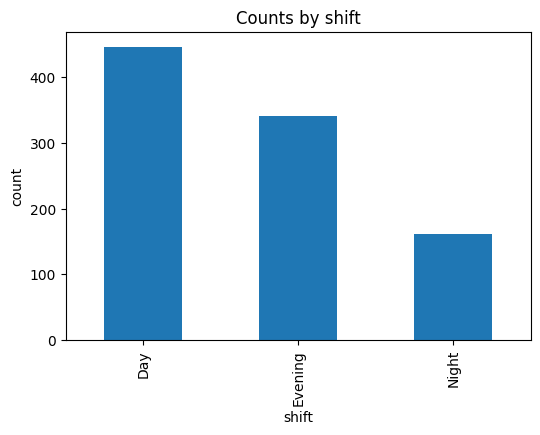

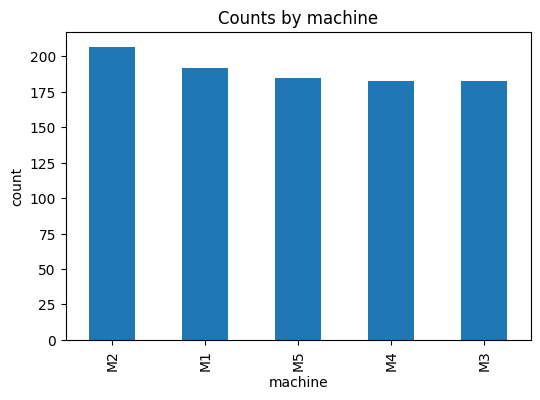

In [34]:
# カテゴリ分布（例：部品別の件数）
num_cols = ["part_type", "shift", "machine", "goodmaterial_batch"]
for c in num_cols:
    if c in df.columns:
        plt.figure()
        df[c].value_counts().plot(kind="bar")
        plt.title(f"Counts by {c}")
        plt.xlabel(c); plt.ylabel("count")
        plt.show()



### 前処理方針
- 目的変数は `good_rate`（0〜1）。`bad_rate` は `1 - good_rate` のため学習には使いません。
- 欠損のある行のうち、`good_rate` が欠損の行は除外します（教師なしになるため）。
- 数量変数は中央値で補完、カテゴリ変数は最頻値で補完します（簡易実装）。
- カテゴリ変数は one-hot エンコーディングでエンコードします。


In [36]:

work = df.copy()

# 目的変数が欠損の行は除外
work = work[~work["good_rate"].isna()].copy()

# 説明に使わない列の例（識別子や重複指標）
drop_cols = ["timestamp", "good_count", "bad_count", "bad_rate"]
for c in drop_cols:
    if c in work.columns:
        work = work.drop(columns=c)

# 数量・カテゴリ列の分割
num_cols = ["temp_c", "pressure_bar", "speed_per_min", "inspected_count"]
cat_cols = ["part_type", "shift", "machine", "material_batch"]

# 補完
for c in num_cols:
    if c in work.columns:
        median = work[c].median()
        work[c] = work[c].fillna(median)

for c in cat_cols:
    if c in work.columns:
        mode = work[c].mode(dropna=True)
        mode_val = mode.iloc[0] if not mode.empty else "UNK"
        work[c] = work[c].fillna(mode_val)

# one-hot encoding
X = pd.get_dummies(work[num_cols + cat_cols], drop_first=False)
y = work["good_rate"].values

print("対象データ数", "説明変数", X.shape, "目的変数", y.shape)
X.head()


対象データ数 説明変数 (950, 21) 目的変数 (950,)


,temp_c,pressure_bar,speed_per_min,inspected_count,part_type_A,part_type_B,part_type_C,part_type_D,part_type_E,shift_Day,shift_Evening,shift_Night,machine_M1,machine_M2,machine_M3,machine_M4,machine_M5,material_batch_Mat1,material_batch_Mat2,material_batch_Mat3,material_batch_Mat4
0,192.578079,49.556930,109.775782,100,False,False,True,False,False,False,True,False,False,False,False,True,False,False,True,False,False
1,209.243578,47.847708,150.471002,100,False,True,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False
2,200.346119,53.982720,119.512885,100,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,True,False
3,197.172043,48.820829,135.420803,100,False,False,True,False,False,True,False,False,False,True,False,False,False,True,False,False,False
4,198.938181,48.466514,119.200457,100,True,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False


## 2. 全データで学習して、学習データ上の精度を確認

In [37]:

model_all = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)
model_all.fit(X, y)

pred_all = model_all.predict(X)
mae_all = mean_absolute_error(y, pred_all)
mse_all = mean_squared_error(y, pred_all)
rmse_all = root_mean_squared_error(y, pred_all)
r2_all = r2_score(y, pred_all)

print(f"[ALL fit]  MAE={mae_all:.5f}, MSE={mse_all:.5f}, RMSE={rmse_all:.5f}, R2={r2_all:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 799
[LightGBM] [Info] Number of data points in the train set: 950, number of used features: 20
[LightGBM] [Info] Start training from score 0.941400
[ALL fit]  MAE=0.00426, MSE=0.00007, RMSE=0.00814, R2=0.9961


### SHAP による特徴重要度の可視化

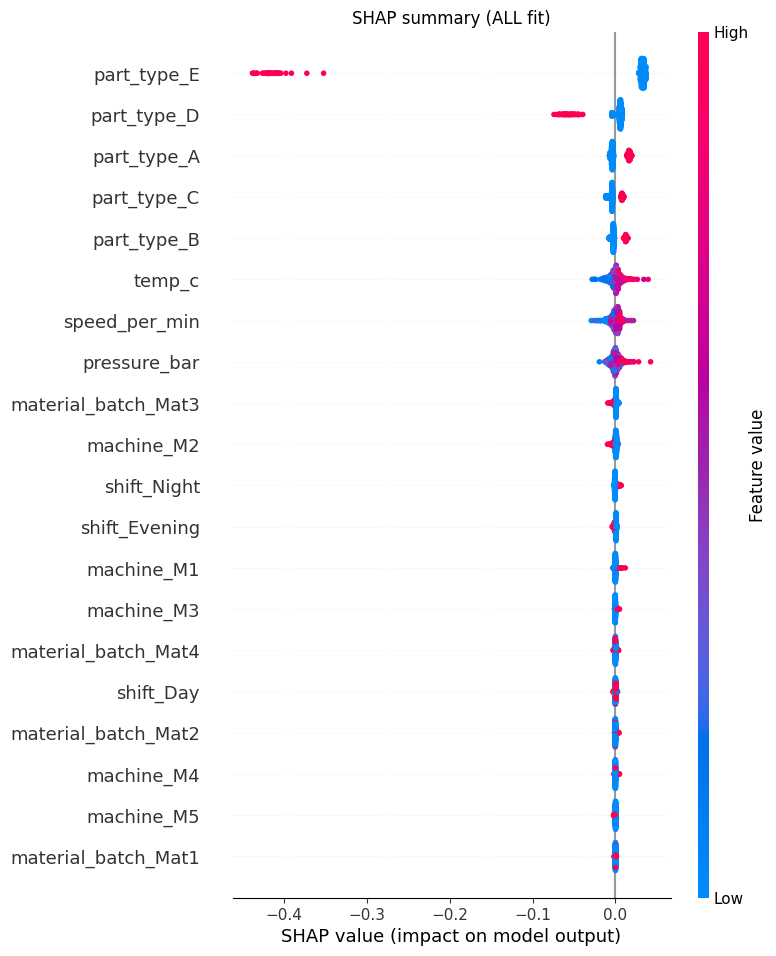

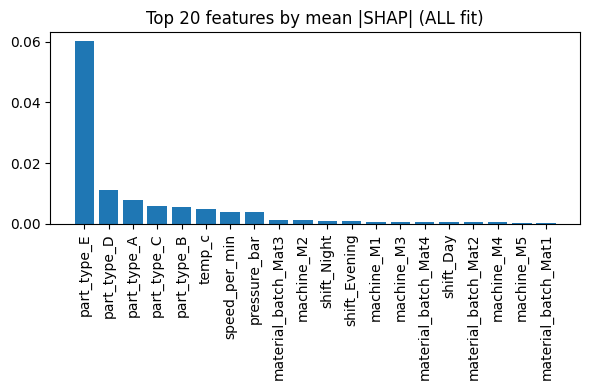

In [38]:

explainer = shap.TreeExplainer(model_all)
# サブサンプル（描画の負荷軽減）
sample_idx = np.random.default_rng(0).choice(len(X), size=min(500, len(X)), replace=False)
X_sample = X.iloc[sample_idx]

shap_values = explainer.shap_values(X_sample)
plt.figure()
shap.summary_plot(shap_values, X_sample, show=False)
plt.title("SHAP summary (ALL fit)")
plt.show()

plt.figure()
# shapのbarプロット（平均絶対SHAP値）
sv_abs_mean = np.abs(shap_values).mean(axis=0)
order = np.argsort(sv_abs_mean)[::-1]
plt.bar(range(len(order[:20])), sv_abs_mean[order[:20]])
plt.xticks(range(len(order[:20])), X_sample.columns[order[:20]], rotation=90)
plt.title("Top 20 features by mean |SHAP| (ALL fit)")
plt.tight_layout()
plt.show()


## 3. 学習用／検証用に分割して評価

In [39]:

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = lgb.LGBMRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_metric="rmse",
    # verbose=False
)

pred_tr = model.predict(X_train)
pred_va = model.predict(X_valid)

mae_tr = mean_absolute_error(y_train, pred_tr)
mse_tr = mean_squared_error(y_train, pred_tr)
rmse_tr = root_mean_squared_error(y_train, pred_tr)
r2_tr = r2_score(y_train, pred_tr)

mae_va = mean_absolute_error(y_valid, pred_va)
mse_va = mean_squared_error(y_valid, pred_va)
rmse_va = root_mean_squared_error(y_valid, pred_va)
r2_va = r2_score(y_valid, pred_va)

print("[Train] MAE={:.5f}, RMSE={:.5f}, R2={:.4f}".format(mae_tr, rmse_tr, r2_tr))
print("[Valid] MAE={:.5f}, RMSE={:.5f}, R2={:.4f}".format(mae_va, rmse_va, r2_va))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 796
[LightGBM] [Info] Number of data points in the train set: 760, number of used features: 20
[LightGBM] [Info] Start training from score 0.942842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

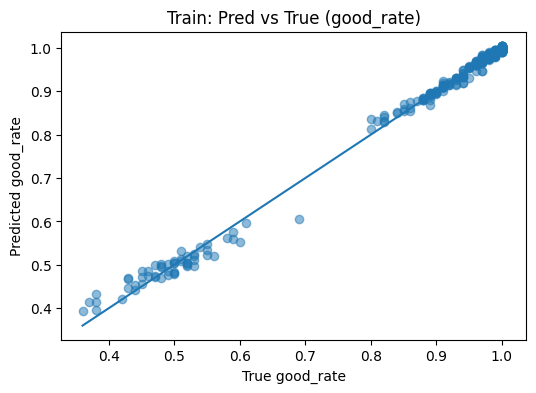

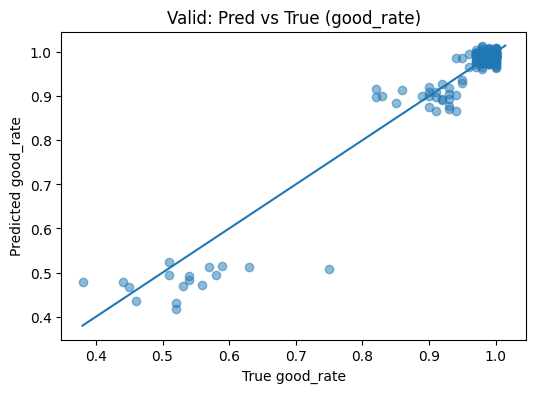

In [40]:

# 学習・検証の予測 vs 実測の散布図
def plot_pred_vs_true(y_true, y_pred, title):
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.5)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims)
    plt.xlabel("True good_rate")
    plt.ylabel("Predicted good_rate")
    plt.title(title)
    plt.show()

plot_pred_vs_true(y_train, pred_tr, "Train: Pred vs True (good_rate)")
plot_pred_vs_true(y_valid, pred_va, "Valid: Pred vs True (good_rate)")


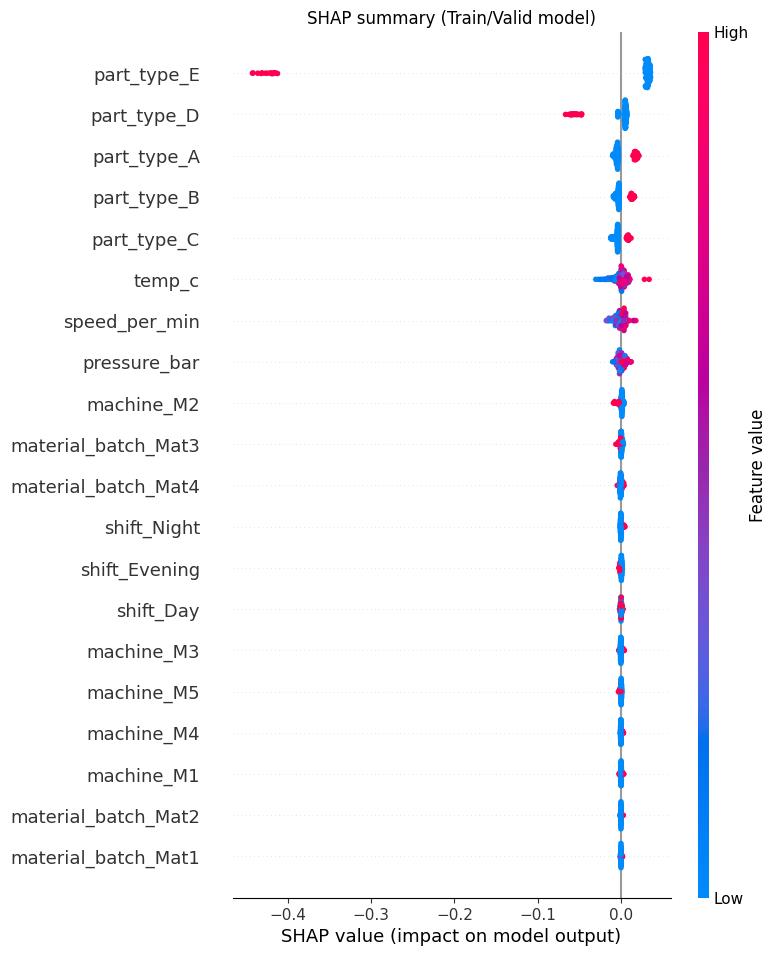

In [41]:

explainer2 = shap.TreeExplainer(model)
sample_idx2 = np.random.default_rng(1).choice(len(X_valid), size=min(500, len(X_valid)), replace=False)
X_val_sample = X_valid.iloc[sample_idx2]

shap_values2 = explainer2.shap_values(X_val_sample)
plt.figure()
shap.summary_plot(shap_values2, X_val_sample, show=False)
plt.title("SHAP summary (Train/Valid model)")
plt.show()
